In [1]:
# https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/

In [3]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


In [5]:
flight_data.shape

(144, 3)

In [9]:
print("Number of years of data:",flight_data.shape[0]/12)

Number of years of data: 12.0


The task is to predict the number of passengers who traveled in the last 12 months based on first 132 months. Remember that we have a record of 144 months, which means that the data from the first 132 months will be used to train our LSTM model, whereas the model performance will be evaluated using the values from the last 12 months.


Let's plot the frequency of the passengers traveling per month. The following script increases the default plot size:

In [10]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

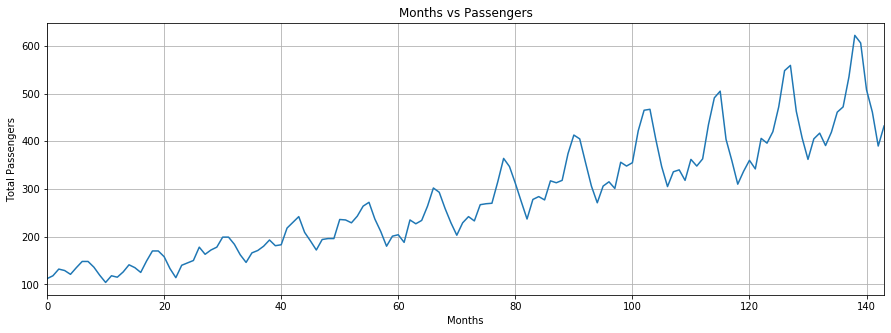

In [14]:
plt.title("Months vs Passengers")
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])

The output shows that over the years the average number of passengers traveling by air increased. The number of passengers traveling within a year fluctuates, which makes sense because during summer or winter vacations, the number of traveling passengers increases compared to the other parts of the year.

# Data Preprocessing

In [15]:
flight_data.columns

Index(['year', 'month', 'passengers'], dtype='object')

The first preprocessing step is to change the type of the passengers column to float.

In [16]:
all_data = flight_data['passengers'].values.astype(float)

In [17]:
print(all_data)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]


Next, we will divide our data set into training and test sets. The LSTM algorithm will be trained on the training set. The model will then be used to make predictions on the test set. The predictions will be compared with the actual values in the test set to evaluate the performance of the trained model.


The first 132 records will be used to train the model and the last 12 records will be used as a test set. The following script divides the data into training and test sets.

In [18]:
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [19]:
print(len(train_data))
print(len(test_data))

132
12


If you now print the test data, you will see it contains last 12 records from the all_data numpy array:

In [20]:
print(test_data)

[417. 391. 419. 461. 472. 535. 622. 606. 508. 461. 390. 432.]


Our dataset is not normalized at the moment. The total number of passengers in the initial years is far less compared to the total number of passengers in the later years. It is very important to normalize the data for time series predictions. We will perform min/max scaling on the dataset which normalizes the data within a certain range of minimum and maximum values. We will be using the MinMaxScaler class from the sklearn.preprocessing module to scale our data. For further details of the min/max scaler implementation, visit this link.

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [23]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-0.96483516]
 [-0.93846154]
 [-0.87692308]
 [-0.89010989]
 [-0.92527473]]
[[1.        ]
 [0.57802198]
 [0.33186813]
 [0.13406593]
 [0.32307692]]


It is important to mention here that data normalization is only applied on the training data and not on the test data. If normalization is applied on the test data, there is a chance that some information will be leaked from training set into the test set.

The next step is to convert our dataset into tensors since PyTorch models are trained using tensors. To convert the dataset into tensors, we can simply pass our dataset to the constructor of the FloatTensor object, as shown below:

In [24]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [26]:
train_data_normalized.shape

torch.Size([132])

The final preprocessing step is to convert our training data into sequences and corresponding labels.

You can use any sequence length and it depends upon the domain knowledge. However, in our dataset it is convenient to use a sequence length of 12 since we have monthly data and there are 12 months in a year. If we had daily data, a better sequence length would have been 365, i.e. the number of days in a year. Therefore, we will set the input sequence length for training to 12.

In [27]:
train_window = 12

In [28]:
def create_inout_sequences(input_data,tw):
    inout_seq=[]
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq,train_label))
    return inout_seq

In [29]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

If you print the length of the train_inout_seq list, you will see that it contains 120 items. This is because though the training set contains 132 elements, the sequence length is 12, which means that the first sequence consists of the first 12 items and the 13th item is the label for the first sequence. Similarly, the second sequence starts from the second item and ends at the 13th item, whereas the 14th item is the label for the second sequence and so on.

Let's now print the first 5 items of the train_inout_seq list:

In [30]:
train_inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]),
  tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]),
  tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]),
  tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]),
  tensor([-0.9077]))]

In [32]:
len(train_inout_seq)

120

# Creating a LSTM Model

In [31]:
class LSTM(nn.Module):
    def __init__(self,input_size=1,hidden_layer_size=100,output_size=1):
        super().__init__()
        
        self.hidden_layer_size = hidden_layer_size
        
        self.lstm = nn.LSTM(input_size,hidden_layer_size)
        
        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(
            input_seq.view(len(input_seq) ,1, -1), 
            self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

Let me summarize what is happening in the above code. The constructor of the LSTM class accepts three parameters:

1. input_size: Corresponds to the number of features in the input. Though our sequence length is 12, for each month we have only 1 value i.e. total number of passengers, therefore the input size will be 1.
2. hidden_layer_size: Specifies the number of hidden layers along with the number of neurons in each layer. We will have one layer of 100 neurons.
3. output_size: The number of items in the output, since we want to predict the number of passengers for 1 month in the future, the output size will be 1.
Next, in the constructor we create variables hidden_layer_size, lstm, linear, and hidden_cell. LSTM algorithm accepts three inputs: previous hidden state, previous cell state and current input. The hidden_cell variable contains the previous hidden and cell state. The lstm and linear layer variables are used to create the LSTM and linear layers.

Inside the forward method, the input_seq is passed as a parameter, which is first passed through the lstm layer. The output of the lstm layer is the hidden and cell states at current time step, along with the output. The output from the lstm layer is passed to the linear layer. The predicted number of passengers is stored in the last item of the predictions list, which is returned to the calling function.

The next step is to create an object of the LSTM() class, define a loss function and the optimizer. Since, we are solving a classification problem, we will use the cross entropy loss. For the optimizer function, we will use the adam optimizer.

In [33]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [34]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


# Training the Model

In [44]:
epochs = 300

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%100 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00668436
epoch: 101 loss: 0.00024563
epoch: 201 loss: 0.00066374
epoch: 299 loss: 0.0006241885


# Make Predictions

Now that our model is trained, we can start to make predictions. Since our test set contains the passenger data for the last 12 months and our model is trained to make predictions using a sequence length of 12. We will first filter the last 12 values from the training set:

In [45]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


You can compare the above values with the last 12 values of the train_data_normalized data list.

Initially the test_inputs item will contain 12 items. Inside a for loop these 12 items will be used to make predictions about the first item from the test set i.e. the item number 133. The predict value will then be appended to the test_inputs list. During the second iteration, again the last 12 items will be used as input and a new prediction will be made which will then be appended to the test_inputs list again. The for loop will execute for 12 times since there are 12 elements in the test set. At the end of the loop the test_inputs list will contain 24 items. The last 12 items will be the predicted values for the test set.

The following script is used to make predictions:

In [46]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

If you print the length of the test_inputs list, you will see it contains 24 items. The last 12 predicted items can be printed as follows:

In [47]:
test_inputs[fut_pred:]

[0.4659651815891266,
 0.607290506362915,
 0.836781919002533,
 0.5582704544067383,
 0.7470318078994751,
 0.7717669010162354,
 0.6676692962646484,
 0.7407524585723877,
 0.9073454737663269,
 0.7969713807106018,
 0.6850457191467285,
 0.7702906131744385]

It is pertinent to mention again that you may get different values depending upon the weights used for training the LSTM.

Since we normalized the dataset for training, the predicted values are also normalized. We need to convert the normalized predicted values into actual predicted values. We can do so by passing the normalized values to the inverse_transform method of the min/max scaler object that we used to normalize our dataset.

In [48]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[437.50707881]
 [469.6585902 ]
 [521.86788657]
 [458.50652838]
 [501.4497363 ]
 [507.07696998]
 [483.3947649 ]
 [500.02118433]
 [537.92109528]
 [512.81098911]
 [487.34790111]
 [506.7411145 ]]


In [49]:
x = np.arange(132, 144, 1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


In the script above we create a list that contains numeric values for the last 12 months. The first month has an index value of 0, therefore the last month will be at index 143.

In the following script, we will plot the total number of passengers for 144 months, along with the predicted number of passengers for the last 12 months.

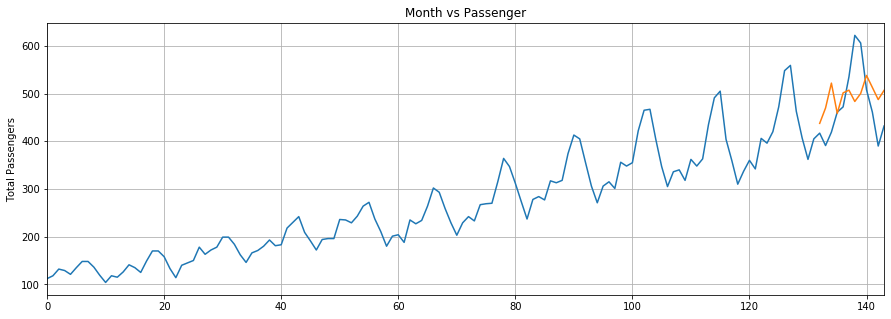

In [50]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

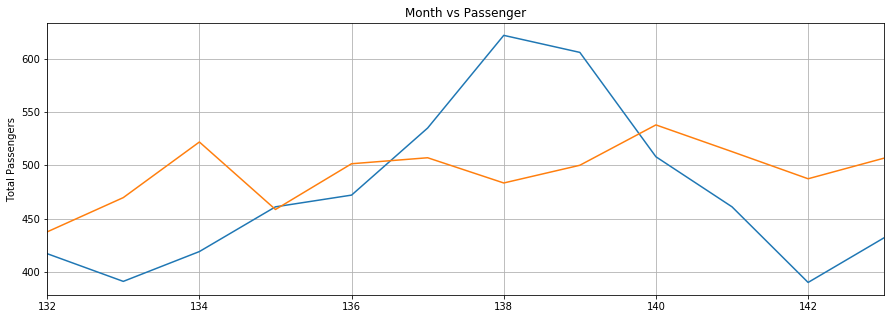

In [51]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()